In [57]:
pip install nba_api pandas numpy tqdm

In [58]:
!pip install tabulate

In [59]:
# Just setups and the imports
import time, math
import numpy as np
import pandas as pd
from tqdm import tqdm

from nba_api.stats.static import players
from nba_api.stats.endpoints import PlayerCareerStats, PlayerGameLog

In [60]:
from os import name
# Finding your player
from ast import Name
TARGETS = ["LeBron James", "Kevin Durant", "Stephen Curry"]

def get_player_id_by_full_name(name:str) -> int:
  matches = players.find_players_by_full_name(name)
  if not matches:
    raise ValueError(f"Sorry no player match for {name}")

  # Exact name match and most recent/active record
  matches = sorted(matches, key=lambda m: (m.get("is_active", False), m["full_name"] == name), reverse=True)
  return matches[0]["id"]

PLAYER_IDS = {name: get_player_id_by_full_name(name) for name in TARGETS}
PLAYER_IDS

{'LeBron James': 2544, 'Kevin Durant': 201142, 'Stephen Curry': 201939}

In [61]:
# I'm sleep deprived so let's quickly organize this and place them in folders

!mkdir -p data/raw data/clean
!ls -R data

data:
clean  raw

data/clean:
playoff_seasons_clean.csv  regular_seasons_enhanced.csv
regular_seasons_clean.csv

data/raw:
playoff_season_totals_raw.csv  regular_season_totals_raw.csv


In [62]:
import time
import pandas as pd
from nba_api.stats.endpoints import PlayerCareerStats

def get_player_seasons(player_id):
    time.sleep(0.7)
    result = PlayerCareerStats(player_id=player_id)
    data = result.get_data_frames()
    reg = data[0].copy()

    if len(data) > 1:
      po  = data[1].copy()
    else:

      po = pd.DataFrame(columns=reg.columns)

    reg["SEASON_TYPE"] = "Regular Season"
    po["SEASON_TYPE"]  = "Playoffs"

    # Ensuring that the seson id and team abbrevitaions are in both dataframes, even if initially missing
    if "SEASON_ID" not in reg.columns:
        reg["SEASON_ID"] = None
    if "TEAM_ABBREVIATION" not in reg.columns:
        reg["TEAM_ABBREVIATION"] = None

    if "SEASON_ID" not in po.columns:
        po["SEASON_ID"] = None
    if "TEAM_ABBREVIATION" not in po.columns:
        po["TEAM_ABBREVIATION"] = None

    return reg, po

# loop through LeBron, KD, Curry's data
regs, pos = [], []
for name, pid in PLAYER_IDS.items():
    r, p = get_player_seasons(pid)
    r["player"] = name
    p["player"] = name
    regs.append(r)
    pos.append(p)

# combining all and saving them as raw csv
regular_raw = pd.concat(regs, ignore_index=True)
playoff_raw = pd.concat(pos,  ignore_index=True)

regular_raw.to_csv("data/raw/regular_season_totals_raw.csv", index=False)
playoff_raw.to_csv("data/raw/playoff_season_totals_raw.csv", index=False)

print("Thanks bro for the raw data now move along down. Shapes:", regular_raw.shape, playoff_raw.shape)

Thanks bro for the raw data now move along down. Shapes: (59, 29) (3, 28)


In [63]:
import numpy as np
import pandas as pd

# We'll just be keeping only the columns we care about
KEEP = ["player","SEASON_ID","SEASON_TYPE","TEAM_ABBREVIATION",
        "GP","GS","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA",
        "OREB","DREB","REB","AST","STL","BLK","TOV","PTS"]

reg = regular_raw[KEEP].copy()
po  = playoff_raw[KEEP].copy()

# Renamed for clarity
reg.rename(columns={"SEASON_ID":"season"}, inplace=True)
po.rename(columns={"SEASON_ID":"season"}, inplace=True)

# This will fix the data types
NUMS = ["GP","GS","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA",
        "OREB","DREB","REB","AST","STL","BLK","TOV","PTS"]

for df in (reg, po):
    for c in NUMS:
        df[c] = pd.to_numeric(df[c], errors="coerce")   # force numbers
    df["season"] = df["season"].astype(str)
    df["TEAM_ABBREVIATION"] = df["TEAM_ABBREVIATION"].astype(str)

# This will remove all the duplicated data
KEYS = ["player","season","SEASON_TYPE","TEAM_ABBREVIATION"]
reg.drop_duplicates(subset=KEYS, keep="last", inplace=True)
po.drop_duplicates(subset=KEYS, keep="last", inplace=True)

# Handle missing numeric values
for df in (reg, po):
    df[NUMS] = df[NUMS].fillna(0)

# Save cleaned versions
reg.to_csv("data/clean/regular_seasons_clean.csv", index=False)
po.to_csv("data/clean/playoff_seasons_clean.csv", index=False)

print("Better thank me for cleaning your mess! Regular rows:", len(reg), "Playoff rows:", len(po))


Better thank me for cleaning your mess! Regular rows: 59 Playoff rows: 3


In [64]:
import pandas as pd

# Reload clean data so this cell works even after a restart
reg = pd.read_csv("data/clean/regular_seasons_clean.csv")
po  = pd.read_csv("data/clean/playoff_seasons_clean.csv")

KEYS = ["player","season","SEASON_TYPE","TEAM_ABBREVIATION"]

print("## Quality Checks on Cleaned Data")

print("\n### Regular Season Data Quality Check")
print("\n#### Missing values per column:")
print(reg.isnull().sum())

print("\n#### Data types:")
print(reg.dtypes)

print("\n#### Number of duplicate rows (by key):")
print(reg.duplicated(subset=KEYS).sum())

print("\n#### Quick preview:")
display(reg.head())

print("\n### Playoff Data Quality Check")
print("\n#### Missing values per column:")
print(po.isnull().sum())

print("\n#### Data types:")
print(po.dtypes)

print("\n#### Number of duplicate rows (by key):")
print(po.duplicated(subset=KEYS).sum())

print("\n#### Quick preview:")
display(po.head())

# Don't worry G the charts displayed are a bunch of unorganized data that are cleaned

## Quality Checks on Cleaned Data

### Regular Season Data Quality Check

#### Missing values per column:
player               0
season               0
SEASON_TYPE          0
TEAM_ABBREVIATION    0
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG3M                 0
FG3A                 0
FTM                  0
FTA                  0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PTS                  0
dtype: int64

#### Data types:
player               object
season               object
SEASON_TYPE          object
TEAM_ABBREVIATION    object
GP                    int64
GS                    int64
MIN                   int64
FGM                   int64
FGA                   int64
FG3M                  int64
FG3A                  int64
FTM                   int64
FTA                   int64
OREB            

,player,season,SEASON_TYPE,TEAM_ABBREVIATION,GP,GS,MIN,FGM,FGA,FG3M,...,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PTS
0,LeBron James,2003-04,Regular Season,CLE,79,79,3120,622,1492,63,...,347,460,99,333,432,465,130,58,273,1654
1,LeBron James,2004-05,Regular Season,CLE,80,80,3388,795,1684,108,...,477,636,111,477,588,577,177,52,262,2175
2,LeBron James,2005-06,Regular Season,CLE,79,79,3361,875,1823,127,...,601,814,75,481,556,521,123,66,260,2478
3,LeBron James,2006-07,Regular Season,CLE,78,78,3190,772,1621,99,...,489,701,83,443,526,470,125,55,250,2132
4,LeBron James,2007-08,Regular Season,CLE,75,74,3027,794,1642,113,...,549,771,133,459,592,539,138,81,255,2250



### Playoff Data Quality Check

#### Missing values per column:
player               0
season               3
SEASON_TYPE          0
TEAM_ABBREVIATION    3
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG3M                 0
FG3A                 0
FTM                  0
FTA                  0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PTS                  0
dtype: int64

#### Data types:
player                object
season               float64
SEASON_TYPE           object
TEAM_ABBREVIATION    float64
GP                     int64
GS                     int64
MIN                    int64
FGM                    int64
FGA                    int64
FG3M                   int64
FG3A                   int64
FTM                    int64
FTA                    int64
OREB                   int64
DREB           

,player,season,SEASON_TYPE,TEAM_ABBREVIATION,GP,GS,MIN,FGM,FGA,FG3M,...,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PTS
0,LeBron James,NaN,Playoffs,NaN,1562,1560,59039,15488,30583,2559,...,8649,11735,1799,9932,11731,11584,2345,1150,5471,42184
1,Kevin Durant,NaN,Playoffs,NaN,1128,1125,41410,10585,21077,2200,...,7337,8319,741,7114,7855,4917,1180,1278,3565,30707
2,Stephen Curry,NaN,Playoffs,NaN,1033,1027,35192,8708,18485,4088,...,4068,4462,670,4174,4844,6571,1564,269,3208,25572


In [65]:
import numpy as np

def add_advanced_metrics(df):
    df = df.copy()

    # Avoid divide-by-zero errors
    def safe_div(a, b):
        return np.where(b == 0, 0, a / b)

    # Efficiency metrics
    df["eFG%"] = safe_div(df["FGM"] + 0.5 * df["FG3M"], df["FGA"])
    df["TS%"]  = safe_div(df["PTS"], 2 * (df["FGA"] + 0.44 * df["FTA"]))

    # Per-game stats
    df["PPG"]  = safe_div(df["PTS"], df["GP"])
    df["RPG"]  = safe_div(df["REB"], df["GP"])
    df["APG"]  = safe_div(df["AST"], df["GP"])
    df["TOV/G"] = safe_div(df["TOV"], df["GP"])

    return df


regular_enhanced = add_advanced_metrics(reg)

# Save it for EDA and charts
regular_enhanced.to_csv("data/clean/regular_seasons_enhanced.csv", index=False)
print("Just some metics, might be confusing dw tho. 'data/clean/regular_seasons_enhanced.csv'")

display(regular_enhanced.head())


Just some metics, might be confusing dw tho. 'data/clean/regular_seasons_enhanced.csv'


,player,season,SEASON_TYPE,TEAM_ABBREVIATION,GP,GS,MIN,FGM,FGA,FG3M,...,STL,BLK,TOV,PTS,eFG%,TS%,PPG,RPG,APG,TOV/G
0,LeBron James,2003-04,Regular Season,CLE,79,79,3120,622,1492,63,...,130,58,273,1654,0.438003,0.488078,20.936709,5.468354,5.886076,3.455696
1,LeBron James,2004-05,Regular Season,CLE,80,80,3388,795,1684,108,...,177,52,262,2175,0.504157,0.553762,27.187500,7.350000,7.212500,3.275000
2,LeBron James,2005-06,Regular Season,CLE,79,79,3361,875,1823,127,...,123,66,260,2478,0.514811,0.568046,31.367089,7.037975,6.594937,3.291139
3,LeBron James,2006-07,Regular Season,CLE,78,78,3190,772,1621,99,...,125,55,250,2132,0.506786,0.552492,27.333333,6.743590,6.025641,3.205128
4,LeBron James,2007-08,Regular Season,CLE,75,74,3027,794,1642,113,...,138,81,255,2250,0.517966,0.567826,30.000000,7.893333,7.186667,3.400000


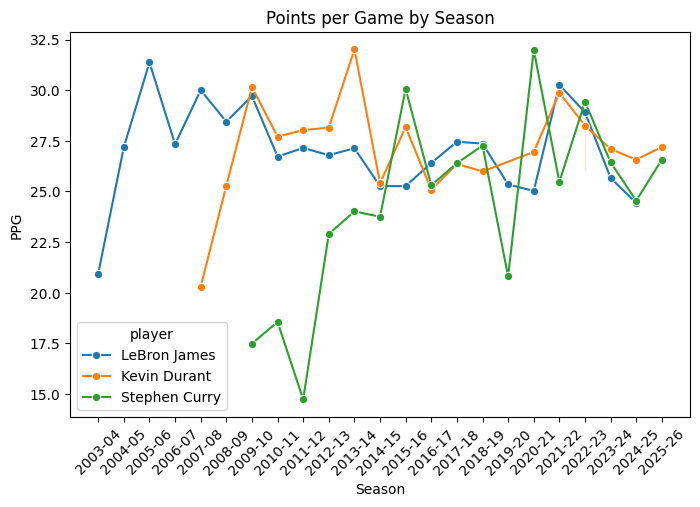

/tmp/ipython-input-1593190073.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="player", y="TS%", ci=None)


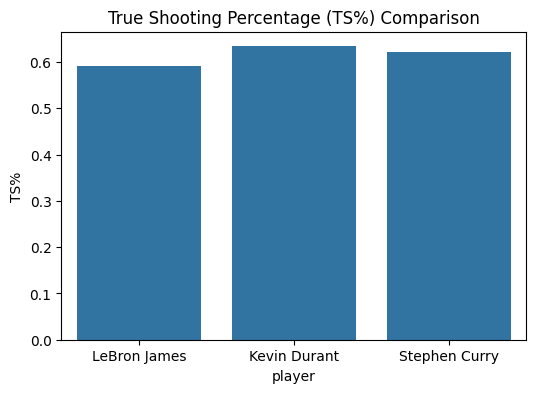

/tmp/ipython-input-1593190073.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="player", y="eFG%", ci=None)


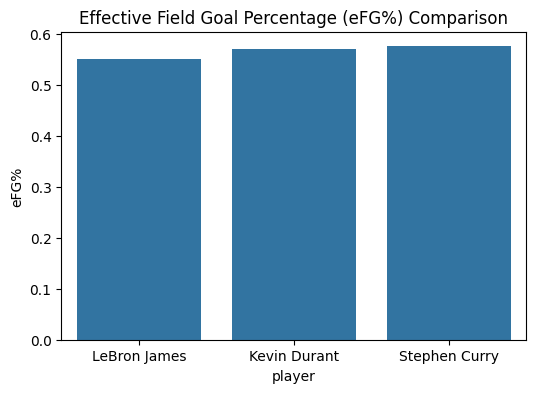

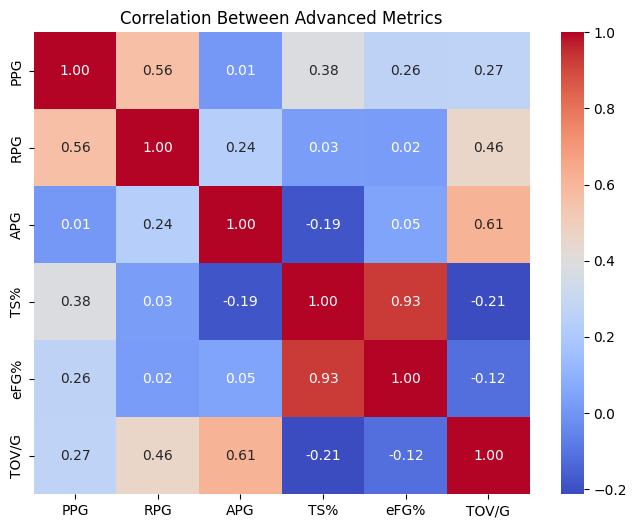

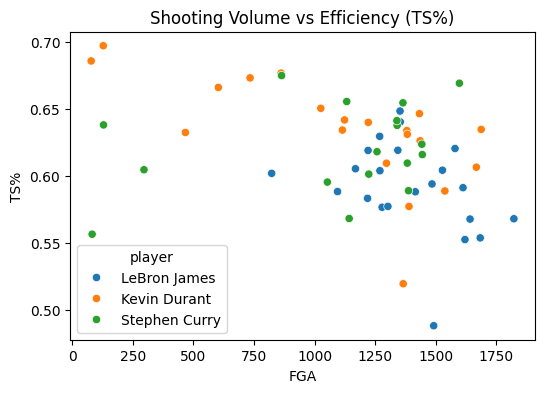

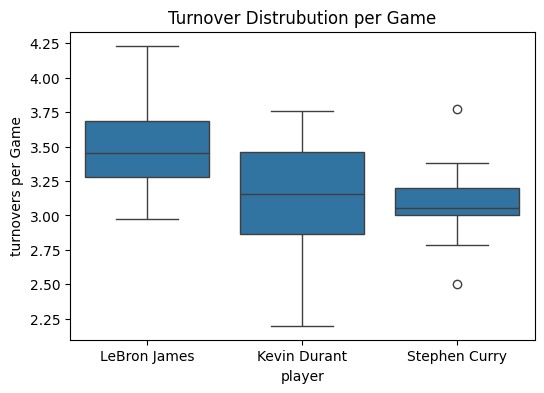

,PPG,RPG,APG,TS%,eFG%
player,,,,,
Kevin Durant,27.25,6.85,4.32,0.63,0.57
LeBron James,27.01,7.55,7.43,0.59,0.55
Stephen Curry,24.45,4.65,6.20,0.62,0.58


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# tried finding a way for matplotlib to show inside Colab
%matplotlib inline

# Pick our clean enhanced dataset
df = regular_enhanced

# This will be their Points-per-Game trend by Season for each player
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="season", y="PPG", hue="player", marker="o")
plt.title("Points per Game by Season")
plt.xlabel("Season")
plt.ylabel("PPG")
plt.xticks(rotation=45)
plt.show()

# This is their Shooting Efficiency Comparison (TS% and eFG%)
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="player", y="TS%", ci=None)
plt.title("True Shooting Percentage (TS%) Comparison")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=df, x="player", y="eFG%", ci=None)
plt.title("Effective Field Goal Percentage (eFG%) Comparison")
plt.show()

# Just a bunch of Correlation heatmap of stats
plt.figure(figsize=(8,6))
sns.heatmap(df[["PPG","RPG","APG","TS%","eFG%","TOV/G"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Advanced Metrics")
plt.show()

#4 Scatter plot: FGA vs TS% (how shot volume affects efficiency)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="FGA", y="TS%", hue="player")
plt.title("Shooting Volume vs Efficiency (TS%)")
plt.show()

# Another Scatter plot lolz
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(data=regular_enhanced, x="player", y="TOV/G")
plt.title("Turnover Distrubution per Game")
plt.xlabel("player")
plt.ylabel("turnovers per Game")
plt.show()

# Just an overview of their stats in numbers
summary = df.groupby("player")[["PPG","RPG","APG","TS%","eFG%"]].mean().round(2)
display(summary)

In [67]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Relevant stats for regression
X = df[["FGA","FG3A","FTA","AST","REB","TOV"]]
y = df["PPG"]

# Fit model
model = LinearRegression().fit(X, y)

# Just shows R^2 (how much variation in PPG is explained)
print("Model R² Score:", round(model.score(X, y), 3))

# Showing which stats most impact scoring
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_.round(2)
})
display(coeffs)


Model R² Score: 0.543


,Feature,Coefficient
0,FGA,-0.01
1,FG3A,0.01
2,FTA,0.02
3,AST,-0.00
4,REB,0.01
5,TOV,-0.03


In [68]:
#when you run this porgram you might get a download mb...
from google.colab import files
files.download("data/clean/regular_seasons_enhanced.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>